* [x] Make it runable
* [x] Check the issue of the order of marices

In [1]:
%matplotlib inline

import numpy as np
import pylab as pl
import subprocess as sp
from astropy.table import Table

import cfuncs as cf
import inps as inp

In [2]:
def convert_one_from_dir(file_name_base, snapid):
    #---------------------------------------
    # Load in particles of one lens plane
    #
    
    zl_array = np.fromfile(file_name_base+str(snapid)+"/"+"redshift."+str(snapid)+".bin", dtype = "f")
    zl_median = np.median(zl_array)
    mp_array = zl_array*0.0+inp.mpp

    xo1 = np.fromfile(file_name_base+str(snapid)+"/"+"theta."+snapid+".bin",dtype = "f")
    xc1 = (xo1.max()+xo1.min())*0.5
    x1_array = (xo1-xc1)*cf.Dc(zl_array)/cf.apr

    xo2 = np.fromfile(file_name_base+str(snapid)+"/"+"phi."+snapid+".bin",dtype = "f")
    xc2 = (xo2.max()+xo2.min())*0.5
    x2_array = (xo2-xc2)*cf.Dc(zl_array)/cf.apr

    xo3 = cf.Dc(zl_array)
    xc3 = (xo3.max()+xo3.min())*0.5
    x3_array = xo3 - xc3
    #---------------------------------------
    # Need talk to Joe, how to conver x, y, z to ra, dec, z
    #
    #
    # xo1 = np.fromfile(file_name_base+str(snapid)+"/"+"x."+snapid+".bin",dtype = ">f")
    # xo2 = np.fromfile(file_name_base+str(snapid)+"/"+"y."+snapid+".bin",dtype = ">f")
    # xo3 = np.fromfile(file_name_base+str(snapid)+"/"+"z."+snapid+".bin",dtype = ">f")
    # xpol3, xpol1, xpol2 =  cart2pol3d(xo1, xo2, xo3)

    # x1_array = np.rad2deg((xpol1 - (xpol1.max()+xpol1.min())*0.5))*3600.*cf.Dc(zl)/cf.apr
    # x2_array = np.rad2deg((xpol2 - (xpol2.max()+xpol2.min())*0.5))*3600.*cf.Dc(zl)/cf.apr
    # x3_array =  xpol3 - (xpol3.max()+xpol3.min())*0.5
    #---------------------------------------
    # Calculate convergence maps
    #
    
    zs = inp.zs0
    ncc = inp.nnn
    bsz_mpc = inp.bsz_arc*cf.Dc(zl_median)/cf.apr
    dsx_mpc = bsz_mpc/ncc

    idx1 = x1_array > -0.5*bsz_mpc
    idx2 = x1_array <= 0.5*bsz_mpc
    idx3 = x2_array > -0.5*bsz_mpc
    idx4 = x2_array <= 0.5*bsz_mpc

    idx = idx1&idx2&idx3&idx4

    x1in = x1_array[idx]
    x2in = x2_array[idx]
    x3in = x3_array[idx]
    mpin = mp_array[idx]

    npp = len(mpin)
    if npp < 200:
        return 1

    sdens_cmpch = cf.call_sph_sdens_weight_omp(x1in,x2in,x3in,mpin,bsz_mpc,ncc)

    file_out_sdens =  inp.sdens_path+str(snapid)+"_"+'%.6f'%(zl_median)+"_sdens.bin"
    sdens_cmpch.astype(np.float32).tofile(file_out_sdens)

    kappa = sdens_cmpch*(1.0+zl_median)**2.0/cf.sigma_crit(zl_median,zs)
    #---------------------------------------
    # Calculate deflection maps
    #
    
    if snapid == '382': # The Snapshot contains the main halo.
        BoundaryCondition = "Isolated"
    else:
        BoundaryCondition = "Periodic"

    BoundaryCondition = "Isolated"
#     BoundaryCondition = "Periodic"

    if BoundaryCondition == "Periodic":
        # if mean(mass) ~ mean(Universe)
        alpha1, alpha2 = cf.call_kappa0_to_alphas_p(kappa, inp.bsz_arc, inp.nnn)
    elif BoundaryCondition == "Isolated":
        # if mean(mass) >> mean(Universe)
        alpha1, alpha2 = cf.call_kappa0_to_alphas(kappa, inp.bsz_arc, inp.nnn)
    else:
        print("You should define the Boundary Condition first!!!")
    #---------------------------------------
    # Calculate higher order lensing maps
    #
    
    al11, al12 = np.gradient(alpha1, inp.dsx_arc)
    al21, al22 = np.gradient(alpha2, inp.dsx_arc)
    mua = 1.0/(1.0 - (al11 + al22) + al11*al22 - al12*al21)
    shear1 = 0.5*(al11 - al22)
    shear2 = 0.5*(al12 + al21)

    return snapid, zl_median, zs, kappa, alpha1, alpha2, shear1, shear2


def main_create_grid_maps_hdf5(haloID):
    data = Table()
    
    nslices = len(inp.snapid_list)
    
    snapid_ar = []
    zl_ar = []
    zs_ar = []
    kappa0_ar = []
    alpha1_ar = []
    alpha2_ar = []
    shear1_ar = []
    shear2_ar = []
    
    for i in range(nslices):
        output_ar = convert_one_from_dir(inp.input_prtcls_dir+"lcCutout", 
                                         inp.snapid_list[i])
        if output_ar == 1:
            continue
        else:
            snapid_ar.append(output_ar[0])
            zl_ar.append(output_ar[1])
            zs_ar.append(output_ar[2])
            kappa0_ar.append(output_ar[3])
            alpha1_ar.append(output_ar[4])
            alpha2_ar.append(output_ar[5])
            shear1_ar.append(output_ar[6])
            shear2_ar.append(output_ar[7])
        
        del output_ar

    data['snapID'] = np.array(snapid_ar, dtype="int")
    data['zl']     = np.array(zl_ar, dtype="float32")
    data['zs']     = np.array(zs_ar, dtype="float32")

    data['kappa0'] = np.array(kappa0_ar, dtype="float32")
    data['alpha1'] = np.array(alpha1_ar, dtype="float32")
    data['alpha2'] = np.array(alpha2_ar, dtype="float32")
    data['shear1'] = np.array(shear1_ar, dtype="float32")
    data['shear2'] = np.array(shear2_ar, dtype="float32")

    del snapid_ar, zl_ar, zs_ar
    del kappa0_ar, alpha1_ar, alpha2_ar, shear1_ar, shear2_ar

    data.write('./outputs/' + haloID + '_gmaps.hdf5',
                       path="/grids_maps", append=True, overwrite=True)#, compression=True)

    return 0


In [3]:
halo_id = inp.halo_info[:-1]
main_create_grid_maps_hdf5(halo_id)

0

In [4]:
def loadin_lens_data_zs0_hdf5(haloID):
    data = Table.read('./outputs/' + haloID + '_gmaps.hdf5', path='/grids_maps')
    
    idx = np.argsort(data['zl'])
    zl_array_zs0 = data['zl'][idx]

    alpha1_array_zs0 = data['alpha1'][idx]
    alpha2_array_zs0 = data['alpha2'][idx]
    kappa0_array_zs0 = data['kappa0'][idx]
    shear1_array_zs0 = data['shear1'][idx]
    shear2_array_zs0 = data['shear2'][idx]   

    return alpha1_array_zs0, alpha2_array_zs0, \
           kappa0_array_zs0, shear1_array_zs0, shear2_array_zs0, \
           zl_array_zs0

#--------------------------------------------------------------------
def ray_tracing_all(alpha1_array,alpha2_array,\
                    kappas_array, shear1_array, shear2_array, \
                    zl_array,zs):
    xx1 = inp.xi1
    xx2 = inp.xi2
    dsi = inp.dsx_arc

    nlpl = len(zl_array)
    af1 = xx1*0.0
    af2 = xx2*0.0
    kf0 = xx1*0.0
    sf1 = xx1*0.0
    sf2 = xx2*0.0

    for i in range(nlpl):
        xj1,xj2 = rec_read_xj(alpha1_array,alpha2_array,zl_array,zs,i+1)
        #------------------
        alpha1_tmp = cf.call_inverse_cic(alpha1_array[i],0.0,0.0,xj1,xj2,dsi)
        af1 = af1 + alpha1_tmp
        alpha2_tmp = cf.call_inverse_cic(alpha2_array[i],0.0,0.0,xj1,xj2,dsi)
        af2 = af2 + alpha2_tmp
        #------------------
        kappa_tmp = cf.call_inverse_cic(kappas_array[i],0.0,0.0,xj1,xj2,dsi)
        kf0 = kf0 + kappa_tmp
        #------------------
        shear1_tmp = cf.call_inverse_cic(shear1_array[i],0.0,0.0,xj1,xj2,dsi)
        sf1 = sf1 + shear1_tmp
        shear2_tmp = cf.call_inverse_cic(shear2_array[i],0.0,0.0,xj1,xj2,dsi)
        sf2 = sf2 + shear2_tmp
        #------------------

    kf0[:inp.npad,:] = 0.0;kf0[-inp.npad:,:] = 0.0;kf0[:,:inp.npad] = 0.0;kf0[:,-inp.npad:] = 0.0;
    sf1[:inp.npad,:] = 0.0;sf1[-inp.npad:,:] = 0.0;sf1[:,:inp.npad] = 0.0;sf1[:,-inp.npad:] = 0.0;
    sf2[:inp.npad,:] = 0.0;sf2[-inp.npad:,:] = 0.0;sf2[:,:inp.npad] = 0.0;sf2[:,-inp.npad:] = 0.0;

    return af1, af2, kf0, sf1, sf2

#--------------------------------------------------------------------
def rec_read_xj(alpha1_array,alpha2_array,zln,zs,n):

    xx1 = inp.xi1
    xx2 = inp.xi2
    dsi = inp.dsx_arc
    nx1 = inp.nnn
    nx2 = inp.nnn

    if n == 0 :
        return xx1*0.0,xx2*0.0

    if n == 1 :
        xx1.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        xx2.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")
        return xx1,xx2

    if n == 2:
        z2 = zln[1]
        z1 = zln[0]
        z0 = 0

        x01 = xx1*0.0
        x02 = xx2*0.0

        try:
            x11 = np.fromfile(inp.xj_path+str(n-2)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            x12 = np.fromfile(inp.xj_path+str(n-2)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-2)+"_xj1.bin")
            x11 = xx1
            x12 = xx2

        aim11 = alpha1_array[n-2]
        aim12 = alpha2_array[n-2]

        ahm11 = cf.ai_to_ah(aim11,z1,zs)
        ahm12 = cf.ai_to_ah(aim12,z1,zs)

        bij = cf.Da(z1)*cf.Da2(z0,z2)/(cf.Da(z2)*cf.Da2(z0,z1))
        x21 = x11*bij-(bij-1)*x01-ahm11*cf.Da2(z1,z2)/cf.Da(z2)
        x22 = x12*bij-(bij-1)*x02-ahm12*cf.Da2(z1,z2)/cf.Da(z2)

        x21.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        x22.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")

        return x21,x22

    if n > 2:
        zi = zln[n-1]
        zim1 = zln[n-2]
        zim2 = zln[n-3]

        try:
            xjm21 = np.fromfile(inp.xj_path+str(n-3)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            xjm22 = np.fromfile(inp.xj_path+str(n-3)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-3)+"_xj1.bin")
            xjm21,xjm22 = rec_read_xj(alpha1_array,alpha2_array,zln,zs,n-2)

        try:
            xjm11 = np.fromfile(inp.xj_path+str(n-2)+"_xj1.bin", dtype='double').reshape((nx1, nx2))
            xjm12 = np.fromfile(inp.xj_path+str(n-2)+"_xj2.bin", dtype='double').reshape((nx1, nx2))
        except:
            print "No %s files, recalculate XJ..."%(inp.xj_path+str(n-2)+"_xj1.bin")
            xjm11,xjm12 = rec_read_xj(alpha1_array,alpha2_array,zln,zs,n-1)

        aijm11 = cf.call_inverse_cic(alpha1_array[n-2],0.0,0.0,xjm11,xjm12,dsi)
        aijm12 = cf.call_inverse_cic(alpha2_array[n-2],0.0,0.0,xjm11,xjm12,dsi)

        ahjm11 = cf.ai_to_ah(aijm11,zim1,zs)
        ahjm12 = cf.ai_to_ah(aijm12,zim1,zs)

        bij = cf.Da(zim1)*cf.Da2(zim2,zi)/cf.Da(zi)/cf.Da2(zim2,zim1)
        xj1 = xjm11*bij-(bij-1)*xjm21-ahjm11*cf.Da2(zim1,zi)/cf.Da(zi)
        xj2 = xjm12*bij-(bij-1)*xjm22-ahjm12*cf.Da2(zim1,zi)/cf.Da(zi)

        xj1.astype('double').tofile(inp.xj_path+str(n-1)+"_xj1.bin")
        xj2.astype('double').tofile(inp.xj_path+str(n-1)+"_xj2.bin")

        return xj1,xj2

In [5]:
def raytraced_grid_maps_for_zs(haloID, ZS):
    #------------------------------------------------------
    # Load in lensing maps
    #
    
    alpha1_array_zs0, \
    alpha2_array_zs0, \
    kappa0_array_zs0, \
    shear1_array_zs0, \
    shear2_array_zs0, \
    zl_array_zs0 = loadin_lens_data_zs0_hdf5(haloID)
    
    xx1 = inp.xi1
    xx2 = inp.xi2
    ZS0 = inp.zs0
    ncc = inp.nnn
    #------------------------------------------------------
    # Rescale Lens Data (zs0->zs)
    #

    zl_array = zl_array_zs0[zl_array_zs0<(ZS)]
    nzlp = len(zl_array)

    alpha1_array = np.zeros((nzlp,ncc,ncc))
    alpha2_array = np.zeros((nzlp,ncc,ncc))
    kappa0_array = np.zeros((nzlp,ncc,ncc))
    shear1_array = np.zeros((nzlp,ncc,ncc))
    shear2_array = np.zeros((nzlp,ncc,ncc))

    print "-----------------------------------------------", ZS, nzlp

    for i in range(nzlp):
        rescale = cf.Da(ZS0)/cf.Da2(zl_array[i],ZS0)*cf.Da2(zl_array[i],ZS)/cf.Da(ZS)
        alpha1_array[i] = alpha1_array_zs0[i]*rescale
        alpha2_array[i] = alpha2_array_zs0[i]*rescale
        kappa0_array[i] = kappa0_array_zs0[i]*rescale
        shear1_array[i] = shear1_array_zs0[i]*rescale
        shear2_array[i] = shear2_array_zs0[i]*rescale

    #------------------------------------------------------
    # Ray-tracing
    #

    af1, af2, kf0, sf1, sf2 = ray_tracing_all(alpha1_array,alpha2_array,
                                              kappa0_array,shear1_array,shear2_array,
                                              zl_array,ZS)
    print "kf0 = ", np.max(kf0)
    print "af1 = ", np.max(af1)
    print "af2 = ", np.max(af2)
    print "sf1 = ", np.max(sf1)
    print "sf2 = ", np.max(sf2)
    #------------------------------------------------------
    # Save Outputs
    #
    data = Table()
    
    data['kf0'] = kf0.astype(np.float32)
    data['af1'] = af1.astype(np.float32)
    data['af2'] = af2.astype(np.float32)
    data['sf1'] = sf1.astype(np.float32)
    data['sf2'] = sf2.astype(np.float32)

    data.write('./outputs/' + haloID + '_' + str(ZS) + '_raytraced_maps.hdf5',
                       path="/raytraced_maps", append=True, overwrite=True)#, compression=True)

    return 0

In [6]:
zs_t = 1.5
raytraced_grid_maps_for_zs(halo_id, zs_t)

----------------------------------------------- 1.5 15
kf0 =  2.16001150705
af1 =  29.7274358672
af2 =  30.7472392355
sf1 =  0.500460461219
sf2 =  0.316593125145


0

In [7]:
def shear_vis_grids(x1, x2, shear1, shear2, kappa):

    nnx, nny = np.shape(kappa)

    # scale_reduced = (1.0-kappa)
    # idx = kappa >= 0.5
    # scale_reduced[idx] = 1.0

    g1 = shear1#/scale_reduced
    g2 = shear2#/scale_reduced
    #---------------------------------------------------------------------
    pl.figure(figsize=(10,10),dpi=80)
#     pl.axes([0.0,0.0,1.0,1.0])
#     pl.axis("off")
    pl.imshow(kappa.T,aspect='equal',cmap=pl.cm.jet,origin='higher', 
              extent=[-inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,
                      -inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,])

    ndiv = 8
    scale_shear = 80

    for i in range(ndiv/2,nnx,ndiv):
        for j in range(ndiv/2,nny,ndiv):
            gt1 = g1[i, j]
            gt2 = g2[i, j]

            ampli = np.sqrt(gt1*gt1+gt2*gt2)
            alph = np.arctan2(gt2,gt1)/2.0

            st_x = x1[i, j]-ampli*np.cos(alph)*scale_shear
            md_x = x1[i, j]
            ed_x = x1[i, j]+ampli*np.cos(alph)*scale_shear

            st_y = x2[i, j]-ampli*np.sin(alph)*scale_shear
            md_y = x2[i, j]
            ed_y = x2[i, j]+ampli*np.sin(alph)*scale_shear

            pl.plot([md_x,ed_x],[md_y,ed_y],'w-',linewidth=1.0)
            pl.plot([md_x,st_x],[md_y,st_y],'w-',linewidth=1.0)
            
    pl.xlim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    pl.ylim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    return 0


def shear_vis_mocks(x1, x2, shear1, shear2, kappa):
    g1 = shear1
    g2 = shear2
    #---------------------------------------------------------------------
    pl.figure(figsize=(10,10),dpi=80)
    pl.imshow(kappa.T,aspect='equal',cmap=pl.cm.jet,origin='higher',
              extent=[-inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,
                      -inp.bsz_arc/2.0,
                       inp.bsz_arc/2.0,])

    scale_shear = 80.0
    ngals = 5000
    index = np.random.choice(np.linspace(0, len(x1)-1, len(x1)).astype('int'), ngals)

    for i in index:
        gt1 = g1[i]
        gt2 = g2[i]

        ampli = np.sqrt(gt1*gt1+gt2*gt2)
        alph = np.arctan2(gt2,gt1)/2.0

        st_x = x1[i]-ampli*np.cos(alph)*scale_shear
        md_x = x1[i]
        ed_x = x1[i]+ampli*np.cos(alph)*scale_shear

        st_y = x2[i]-ampli*np.sin(alph)*scale_shear
        md_y = x2[i]
        ed_y = x2[i]+ampli*np.sin(alph)*scale_shear

        pl.plot([md_x,ed_x],[md_y,ed_y],'w-',linewidth=1.0)
        pl.plot([md_x,st_x],[md_y,st_y],'w-',linewidth=1.0)

    pl.xlim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)
    pl.ylim(-inp.bsz_arc/2.0, inp.bsz_arc/2.0)

    return 0

#------------------------------------------------------------------------------
def main_make_mocks(haloID, zs, plot_shears=True):
    xx1 = inp.xi1
    xx2 = inp.xi2

    #------------------------------------------------------
    # gtheta = np.fromfile(inp.gals_path+"theta_1.5_gals.bin", dtype='float32')
    # gphi = np.fromfile(inp.gals_path+"phi_1.5_gals.bin", dtype='float32')
    # ys1_array = (gtheta/3600.0-87.5)*3600.
    # ys2_array = (gphi/3600.0-2.5)*3600.
    
    nsrcs = 6000
    ys1_array = np.random.random(nsrcs)*inp.bsz_arc-inp.bsz_arc*0.5
    ys2_array = np.random.random(nsrcs)*inp.bsz_arc-inp.bsz_arc*0.5
    
    data = Table.read('./outputs/' + haloID + '_' + str(zs) + '_raytraced_maps.hdf5', path='/raytraced_maps')

    af1 = data['af1']
    af2 = data['af2']
    kf0 = data['kf0']
    sf1 = data['sf1']
    sf2 = data['sf2']

    del data
    #------------------------------------------------------
    # Deflection Angles and lensed Positions
    #

    yf1 = xx1 - af1
    yf2 = xx2 - af2
    xr1_array, xr2_array = cf.call_mapping_triangles_arrays_omp(ys1_array,ys2_array,xx1,xx2,yf1,yf2)
    # xr1_array, xr2_array = ys1_array, ys2_array
    #------------------------------------------------------
    # Update Lensing Signals of Lensed Positions
    #

    kr0_array = cf.call_inverse_cic_single(kf0,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    sr1_array = cf.call_inverse_cic_single(sf1,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    sr2_array = cf.call_inverse_cic_single(sf2,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)

    mfa = cf.alphas_to_mu(af1, af2, inp.bsz_arc,inp.nnn)
    mra_array = cf.call_inverse_cic_single(mfa,0.0,0.0,xr1_array,xr2_array,inp.dsx_arc)
    #------------------------------------------------------
    # Save Outputs
    #

#     xr1_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_xr1.bin")
#     xr2_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_xr2.bin")
#     kr0_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_kr0.bin")
#     sr1_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_sr1.bin")
#     sr2_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_sr2.bin")
#     mra_array.astype('float32').tofile(inp.mocks_path + "cl_" + '%.6f'%(zs) + "_mra.bin")

    data = Table()
    
    data['xr1'] = xr1_array.astype('float32')
    data['xr2'] = xr2_array.astype('float32')
    data['kr0'] = kr0_array.astype('float32')
    data['sr1'] = sr1_array.astype('float32')
    data['sr2'] = sr2_array.astype('float32')
    data['mra'] = mra_array.astype('float32')
    
    data.write('./outputs/' + haloID + '_' + str(zs) + '_lensing_mocks.hdf5',
               path="/lensing_mocks", append=True, overwrite=True)#, compression=True)

    if plot_shears:
        shear_vis_mocks(xr1_array, xr2_array, sr1_array, sr2_array, kf0)
        shear_vis_grids(xx1, xx2, sf1, sf2, kf0)
    else:
        pass

    return 0

0

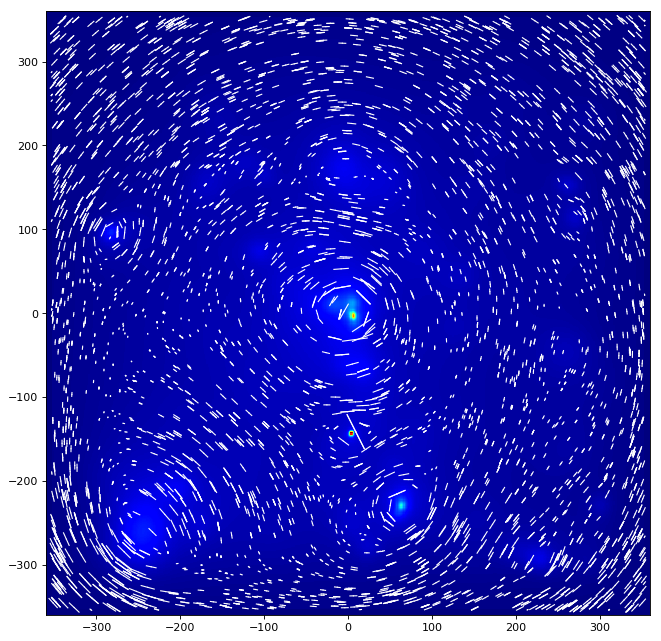

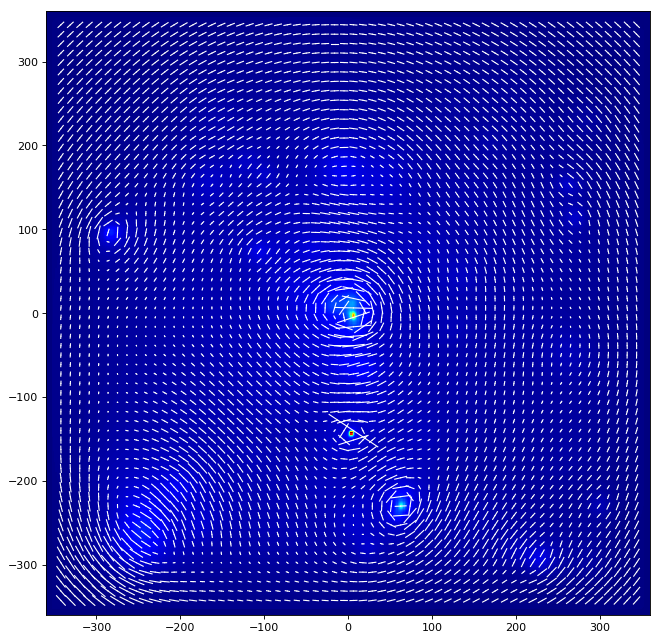

In [8]:
main_make_mocks(halo_id, zs_t)